<a href="https://colab.research.google.com/github/rafeekpro/Colab/blob/main/Copia_de_HumanPoseEstimationWithDeepNeuralNetworks01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-12-01 10:43:21--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  37.0MB/s    in 6.2s    

2020-12-01 10:43:28 (27.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-12-01 10:43:28--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  19.4MB/s    in 3.2s    

2020-12-01 10:43:31 (19.4 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [ ]:
train = sio.loadmat('train_32x32.mat')
test = sio.loadmat('test_32x32.mat')

In [ ]:
# access to the dict
X_train = train['X']
y_train = train['y']
X_test = test['X']
y_test = test['y']

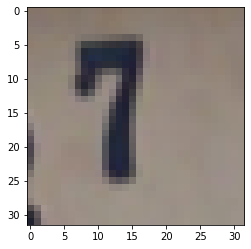

In [ ]:
plt.imshow(X_train[:,:,:,99]);

In [ ]:
print("Digit Label", y_train[99][0])

Digit Label 7


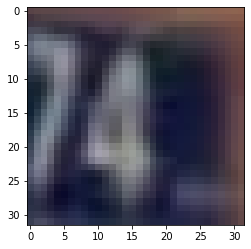

In [ ]:
plt.imshow(X_test[:,:,:,100]);

In [ ]:
print("Digit Label", y_test[100][0])

Digit Label 4


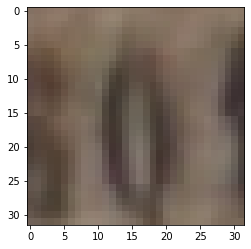

In [ ]:
plt.imshow(X_train[:,:,:,52]);

In [ ]:
print("Digit Label", y_train[52][0])

Digit Label 10


In [ ]:
for index, y in enumerate(y_train):
  if y_train[index] == 10:
    y_train[index] = 0

In [ ]:
print("Digit Label", y_train[52][0])

Digit Label 0


In [ ]:
!pip install boto3

     |████████████████████████████████| 133kB 13.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 6.9MB 18.3MB/s 
     |████████████████████████████████| 143kB 49.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip'] #, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


In [ ]:
# read the meta data of the validation set
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)

In [ ]:
# get its structure
meta.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
# view the structure
# keypoints: x and y locations and visibility (v) of the 17 keypoints. Format: [x0,y0,v0,x1,y1,v1,…x16,y16,v16]

print("Keypoints:", meta["categories"][0]['keypoints'])

Keypoints: ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [ ]:
print("Annot:",  meta["annotations"][0].keys())

Annot: dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])


In [ ]:
number = 0

image_annotations = meta["annotations"][number]


imagefile = str(image_annotations["image_id"])
imagefile = imagefile.zfill(12) +".jpg" #img_info["file_name"]
print(imagefile, image_annotations["image_id"])

000000425226.jpg 425226


In [ ]:
def resize_image(img, target_width=192, target_height=256):
  img_resized = cv2.resize(img,(target_width,target_height))
  return img_resized


def crop_image(img, upper_left_corner, size):
  start_x, start_y = upper_left_corner
  w,h = size
  img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
  return img_cropped


def adjust_keypoint(keypoint, start, scale):
  keypoint_x, keypoint_y= keypoint
  start_x,start_y = start
  sx,sy = scale
  x = (keypoint_x-start_x)*sx
  y = (keypoint_y-start_y)*sy
  return x,y

In [ ]:
%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# params
target_width = 192
target_height= 256

keypoints = image_annotations["keypoints"]


(640, 480, 3) 73.35 206.02 300.58 372.5


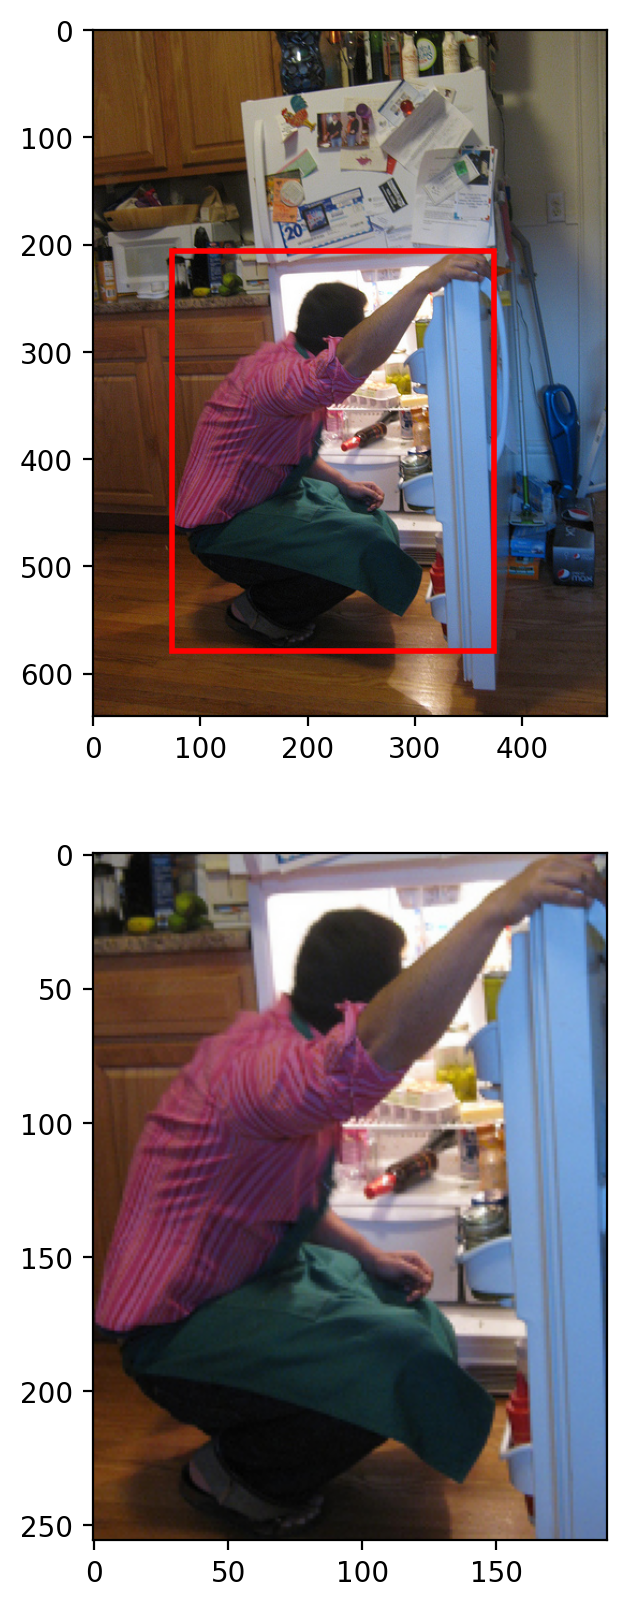

In [ ]:
# plot
fig,ax = plt.subplots(2,figsize=(20,10))
fig.set_dpi(200)

loaded_image = image.imread("val2017//"+imagefile)
start_x,start_y, w,h = image_annotations["bbox"]
print(loaded_image.shape,start_x,start_y,w,h)

r = patches.Rectangle((start_x,start_y),w,h,linewidth=2,edgecolor='r',facecolor='None')

ax[0].imshow(loaded_image)
ax[0].add_patch(r)

img_cropped = crop_image(loaded_image, (start_x,start_y),(w,h))
img_cropped = resize_image(img_cropped,target_width,target_height)


sx = target_width/w 
sy = target_height/h

ax[1].imshow(img_cropped)


In [ ]:
keypoints[8]

0

(640, 480, 3) 73.35 206.02 300.58 372.5


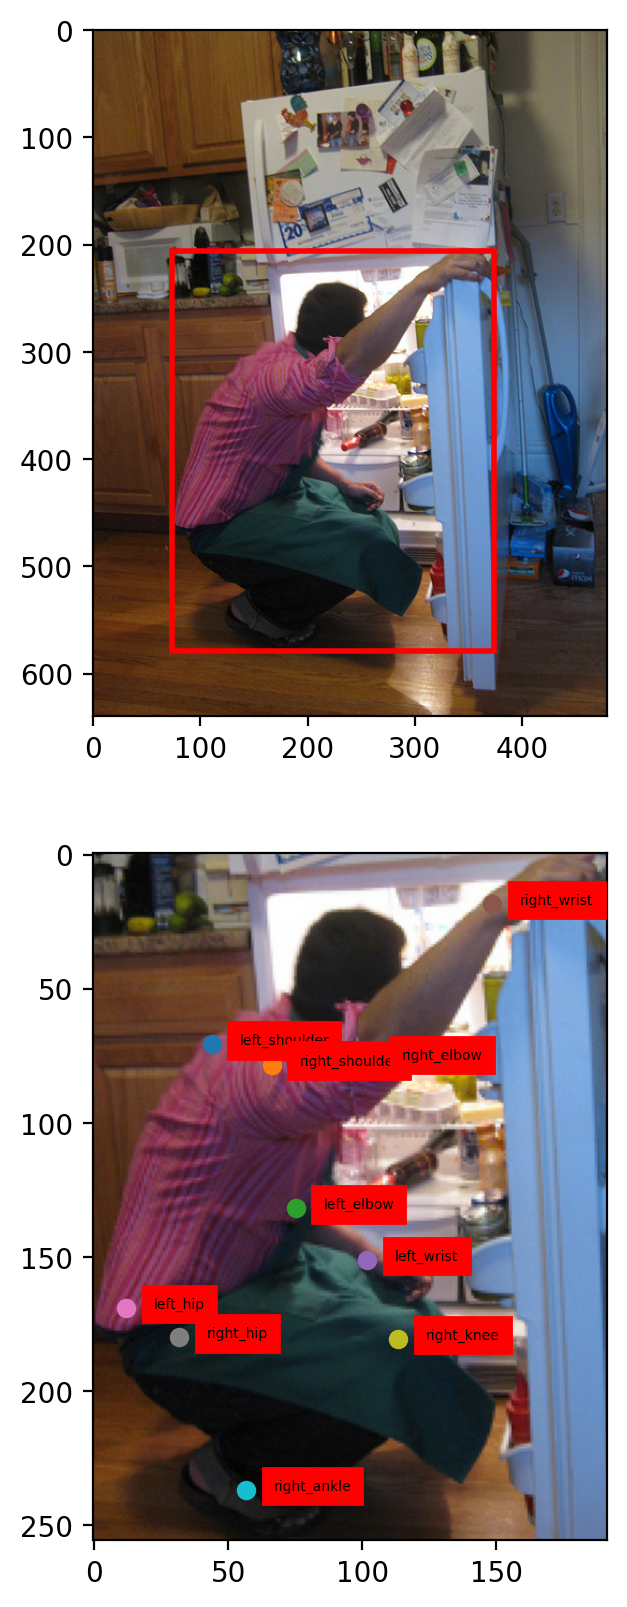

In [ ]:

# plot
fig,ax = plt.subplots(2,figsize=(20,10))
fig.set_dpi(200)

loaded_image = image.imread("val2017//"+imagefile)
start_x,start_y, w,h = image_annotations["bbox"]
print(loaded_image.shape,start_x,start_y,w,h)

r = patches.Rectangle((start_x,start_y),w,h,linewidth=2,edgecolor='r',facecolor='None')

ax[0].imshow(loaded_image)
ax[0].add_patch(r)

img_cropped = crop_image(loaded_image, (start_x,start_y),(w,h))
img_cropped = resize_image(img_cropped,target_width,target_height)


sx = target_width/w 
sy = target_height/h

ax[1].imshow(img_cropped)

for i in range(len(keypoints)//3):
  keypoint = (keypoints[i*3],keypoints[i*3+1])
  visible = keypoints[i*3+2]
  x,y = adjust_keypoint(keypoint,(start_x,start_y),(sx,sy))
  
  if visible:
    # ax.text(x, y, "x")
    # label = img_catogory[i]
    label = meta["categories"][0]['keypoints'][i]
    ax[1].annotate(label,
                 (x,y), 
                 textcoords="offset points",
                 size=5,
                 xytext=(10,0),
                 ha='left',
                 backgroundcolor="r")
    
    ax[1].scatter(x,y)
    
plt.show()